

En esta aplicación implementaremos un modelo de puntuación de riesgo poblacional a la mortalidad debido a los cánceres más comunes y su relación con las cantidades y tecnologías usadas en radioterapia.



riesgo de impago siguiendo la metodología  que hemos analizado en la presentación de clase (selección de variables mediante valor de la información, tramificación de variables continuas, agrupación de categorías, transformación woe de variables, estimación de modelos de regresión logística, ....)



# Como en este caso usaremos Colab, no necesitaremos instalar librerías, pero sí cargarlas en este entorno. En esta primera celda, se cargarán todas las librerías necesarias para ejecutar el TFM del notebook


In [1]:
#Cargo o importo pandas, numpy, Matplotlib,
import pandas as pd
import numpy as np

from urllib.parse import quote
import unicodedata
import matplotlib.pyplot as plt
import os
fig_dir = "figuras"
os.makedirs(fig_dir, exist_ok=True)

#########################



# Carga, Exploración y Preparación de los datos sobre equipos de radioterapia y pacientes
Se utilizará una base de datos de créditos DIRAN de la IAEA junto con los de la OMS, son datos reales, se buscará el año más actual y que tenga lo menos posible la influencia del COVID-19.


Los datos pueden descargarse en la página de la IAEA en el apartado de DIRAC https://dirac.iaea.org/Query/Countries  donde aparecen reflejados los datos de los equipos de radioterapia y el año de sus ultimas actualizaciones a nivel the hardware, por otro lado, se descargaron los datos de la OMS, en el Global Cancer Observatory, donde se descargaron tanto las incidencias como las mortalidades por cáncer a nivel mundial https://gco.iarc.fr/overtime/en/dataviz/trends?populations=752&sexes=1_2&types=1&multiple_populations=1.




## Carga de datos del DIRAC

In [2]:
# Cargamos los datos
url_dirac = (
    "https://raw.githubusercontent.com/mehrerm/TFM/main/"
    "data/raw/DIRAC_Countries.xlsx"
)

dirac = pd.read_excel(url_dirac)


## Análisis exploratorio

In [3]:
dirac.head()



,Country,Region Name,RTCenters With RT,He Photon And Electron Beam Rt,Proton Ion Therapy,XRay Generator,Brachy Therapy Inc El,Last Update
0,Albania,Southern Europe,3,5,0,1,0,2025
1,Algeria,Northern Africa,15,37,0,0,9,2023
2,Angola,Middle Africa,2,3,0,0,1,2023
3,Argentina,South America,89,131,0,8,47,2025
4,Armenia,Western Asia,2,5,0,0,3,2025


In [4]:
dirac.shape

(156, 8)

In [5]:
dirac.columns


Index(['Country', 'Region Name', 'RTCenters With RT',
       'He Photon And Electron Beam Rt', 'Proton Ion Therapy',
       'XRay Generator', 'Brachy Therapy Inc El', 'Last Update'],
      dtype='object')

In [6]:
dirac.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Country                         155 non-null    object
 1   Region Name                     155 non-null    object
 2   RTCenters With RT               156 non-null    int64 
 3   He Photon And Electron Beam Rt  156 non-null    int64 
 4   Proton Ion Therapy              156 non-null    int64 
 5   XRay Generator                  156 non-null    int64 
 6   Brachy Therapy Inc El           156 non-null    int64 
 7   Last Update                     156 non-null    object
dtypes: int64(5), object(3)
memory usage: 9.9+ KB


##Variables encontradas
Entonces, con estos datos se tiene lo siguiente:

'Country' = país

'Region Name' = es el lugar del continente donde se encuentra ese país

'RTCenters With RT' = número de centros con equipos de radioterapia

'He Photon And Electron Beam Rt' = número de centros con teleterapia usando fotones y electrones

'Proton Ion Therapy'= protonterapia

'XRay Generator' = generadores de rayos X

'Brachy Therapy Inc El' = equipos de braquiterapia, incluyendo los equipos en miniatura de rayos X

'Last Update' = las ultimas actualizaciones

Con esta primera exploración se encuentra que no hay datos nulos, se tiene un conjunto de datos cualitativos nominales, com el país y la región, y una variable temporal correspondiente a la fecha de la ultima actialización, asimismo se tienen variables cuantitativas discretas donde están el número de centros y equipos de tratamiento.

Ahora se realiza un análisis exploratorio para buscar outliers, si es que los hay.


In [7]:
categ_vars = dirac.select_dtypes(include='object').columns


In [8]:
#se eliminan espacios al inicio o final de cada nombre
#for col in categ_vars:
 #   dirac[col] = dirac[col].str.strip()


for col in categ_vars:
    print(f"Valores únicos en {col}:")
    print(dirac[col].unique())
    print("-" * 40)

Valores únicos en Country:
['Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Bermuda' 'Bolivia, Plurinational State of'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Cambodia' 'Cameroon' 'Canada' 'Chile' 'China'
 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic'
 "Côte d'Ivoire" 'Dem. P.R. of Korea' 'Democratic Republic of the Congo'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia'
 'Ethiopia' 'Finland' 'France' 'Gabon' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Guadeloupe' 'Guatemala' 'Guyana' 'Honduras' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Israel'
 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya'
 'Korea, Republic of' 'Kuwait' 'Kyrgyzstan'
 "Lao People's Democratic Republic" 'Latvia' 'Lebanon' 'Libya' 'Lithuania'
 'Luxembourg' 'Macau

En este primera análisis exploratorio, parece que existen unos valores anómalos, se explora entonces qué información existe cuando se trata de "nan" y "Latest: 2025"

In [9]:
dirac[dirac['Last Update'] == 'Latest: 2025']





,Country,Region Name,RTCenters With RT,He Photon And Electron Beam Rt,Proton Ion Therapy,XRay Generator,Brachy Therapy Inc El,Last Update
155,NaN,NaN,8620,17162,133,706,3359,Latest: 2025


Esto parece más bien que es la última fila con todos los equipos.

In [10]:
dirac['Country'].isna().sum()

np.int64(1)

In [11]:
dirac["Region Name"].isna().sum()

np.int64(1)

Con esto se demuestra que estos valores anómalos están en la última fila por consecuencia de sumar todos los equipos y centros y calcular la última actualización, entonces, esta fila se eliminará de los datos. Otra operación que sería interesante modificar son los nombres con caracteres que nos podría dar problemas, así como asegurarse de que no hay paises repetidos.

In [12]:
dirac = dirac.drop(index=155)
#queda eliminada la ultima fila
dirac = dirac.drop(columns=["Region name"], errors="ignore")
#Ya que el análisis será por país, ya luego se verá si la región tiene sentido.

dirac['Country'].value_counts().sort_values(ascending=False)


,count
Country,
Albania,1
Algeria,1
Angola,1
Argentina,1
Armenia,1
...,...
"Venezuela, Bolivarian Republic of",1
Viet Nam,1
Yemen,1


In [13]:
#se ha realizado una exploración anticipada de los paises, y se ha detectado que
#varios han sido escritos de manera diferente a los de GLOBOCAN, por lo tanto,
#se reliza de una corrección de los nombres tanto para los de DIRAC como
#los de GLOBOCAN

country_mapping = {

    "Macau, China": "China",
    "Taiwan, China": "China",

    'Czech Republic': 'Czechia',

    "UK, England": "United Kingdom",
    "UK, Wales": "United Kingdom",
    "UK, Scotland": "United Kingdom",
    "UK, Northern Ireland": "United Kingdom",
    "UK, England and wales": "United Kingdom",


    "France (metropolitan)": "France",
    "France, Martinique": "Martinique",

    "USA": "United States of America",


    "Korea, Republic of": "South Korea",


    "Iran, Islamic Republic of": "Iran",

    "Viet Nam": "Vietnam",

    'Venezuela, Bolivarian Republic of': 'Venezuela',

    'Bolivia, Plurinational State of': 'Bolivia',

    "Netherlands, Kingdom of the": "The Netherlands",

    "Republic of Moldova": "Moldova"

}

dirac["Country_harmonized"] = dirac["Country"].replace(country_mapping)

dirac["Country_harmonized"] = dirac["Country_harmonized"].apply(
    lambda x: unicodedata.normalize("NFKD", x)
        .encode("ASCII", "ignore")
        .decode("utf-8") if pd.notna(x) else x
)


Debido a que hay países que están segregados por zonas, se unificará usando Country_harmonized.

Durante el proceso de armonización geográfica se identificaron territorios no soberanos, como Martinica, que inicialmente se consideraron candidatos a ser integrados bajo el Estado correspondiente (Francia). No obstante, un análisis exploratorio de los datos epidemiológicos reveló diferencias sustanciales entre Francia y Martinica en las variables clave de GLOBOCAN, tales como la tasa estandarizada por edad (ASR World), la tasa bruta, el riesgo acumulado y el número total de casos. Por lo tanto, se usarán por separado, algo que no ocurre con UK, donde todo el territorio tiene resultados estadísticos similares.

Adicionalmente, se constató que ambas fuentes de datos empleadas en este estudio, GLOBOCAN y DIRAC, proporcionan información diferenciada para Martinica y Francia. En consecuencia, y con el fin de preservar la coherencia interna de los datos y evitar la introducción de sesgos derivados de agregaciones no justificadas, se decidió mantener Martinica como una entidad separada en el análisis.


In [14]:
# Comprobar duplicados por país
n_dups = dirac["Country_harmonized"].duplicated().sum()

if n_dups > 0:
    num_cols = dirac.select_dtypes(include="number").columns.tolist()

    # Last Update NO se suma, se queda el más reciente
    if "Last Update" in num_cols:
        num_cols.remove("Last Update")

    dirac_clean = (
        dirac
        .groupby("Country_harmonized", as_index=False)
        .agg(
            {**{c: "sum" for c in num_cols},
             "Last Update": "max"}
        )
    )
else:
  dirac_clean = dirac.copy()


dirac_clean["Country_harmonized"].duplicated().sum()




np.int64(0)

Dado que el único campo no numérico del conjunto DIRAC corresponde al año de la última actualización, no fue necesario aplicar reglas de agregación adicionales para variables categóricas.

In [15]:
dirac_clean['Country_harmonized'].unique()

array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Bermuda',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Cambodia',
       'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       'Dem. P.R. of Korea', 'Democratic Republic of the Congo',
       'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guyana',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyzstan',
       "Lao People's Democratic Republi

Se ha limpiado de caracteres anómalos.
Con losdatos numéricos entonces, se analiza si existe algun dato anomalo

In [16]:
datos_numericos = dirac_clean.select_dtypes(include=['int64'])

datos_numericos.describe().T



,count,mean,std,min,25%,50%,75%,max
RTCenters With RT,153.0,56.339869,237.468784,1.0,2.0,6.0,25.0,2237.0
He Photon And Electron Beam Rt,153.0,112.169935,419.628623,1.0,3.0,16.0,57.0,3892.0
Proton Ion Therapy,153.0,0.869281,4.397506,0.0,0.0,0.0,0.0,44.0
XRay Generator,153.0,4.614379,16.112321,0.0,0.0,0.0,1.0,124.0
Brachy Therapy Inc El,153.0,21.954248,67.180662,0.0,1.0,3.0,14.0,638.0


Con estos resultados, se puede saber que hay paises con valores extremos y otros donde escasamente hay un solo equipo. Se puede ver que hay paises donde es cero en equipos mientras que otros tienen hasta 2237 centros con radioterapia, esto tiene sentido si se explora que paises son.


In [17]:
# Lista de variables que representan centros/equipos
columnas_equipos = [
    'RTCenters With RT',
    'He Photon And Electron Beam Rt',
    'Proton Ion Therapy',
    'XRay Generator',
    'Brachy Therapy Inc El'
]

# Mostrar el Top 5 por cada columna
for col in columnas_equipos:
    print(f"\n Top 5 países por: {col}")
    top5 = dirac_clean[['Country_harmonized', col]].sort_values(by=col, ascending=False).head(5)
    print(top5.to_string(index=False))




 Top 5 países por: RTCenters With RT
      Country_harmonized  RTCenters With RT
United States of America               2237
                   China               1699
                   Japan                759
                   India                464
                 Germany                307

 Top 5 países por: He Photon And Electron Beam Rt
      Country_harmonized  He Photon And Electron Beam Rt
United States of America                            3892
                   China                            3090
                   Japan                            1067
                   India                             793
                 Germany                             587

 Top 5 países por: Proton Ion Therapy
      Country_harmonized  Proton Ion Therapy
United States of America                  44
                   Japan                  24
                   China                  19
                 Germany                   7
          United Kingdom                 

In [18]:
dirac_clean.head()

,Country_harmonized,RTCenters With RT,He Photon And Electron Beam Rt,Proton Ion Therapy,XRay Generator,Brachy Therapy Inc El,Last Update
0,Albania,3,5,0,1,0,2025
1,Algeria,15,37,0,0,9,2023
2,Angola,2,3,0,0,1,2023
3,Argentina,89,131,0,8,47,2025
4,Armenia,2,5,0,0,3,2025


Con estos resultados es necesario tener entonces los datos demograficos por país, ademas de los datos de cancer.
#Ahora, a explorar y depurar los datos provenientes de GLOBOCAN.

Para esto, se ha tomado seis tipos de cancer muy comunes: Pulmon, mama, prostata, colon, cervix y leucemia.

In [19]:


# URL base del repositorio
url_base = "https://raw.githubusercontent.com/mehrerm/TFM/main/data/raw/"

# Archivos de cáncer
files_cancer = {
    "lung": "dataset-asr-inc-and-mort-males-and-females-lung.csv",
    "breast": "dataset-asr-inc-and-mort-males-and-females-breast.csv",
    "prostate": "dataset-asr-inc-and-mort-males-and-females-prostat.csv",
    "colon": "dataset-asr-inc-and-mort-males-and-females-colon.csv",
    "cervix": "dataset-asr-inc-and-mort-males-and-females-cervix-uterino.csv",
    "leukaemia": "dataset-asr-inc-and-mort-males-and-females-leukaemia.csv",
}

# Carga de datasets
dfd_cancer = []

for cancer, filename in files_cancer.items():
    url = url_base + quote(filename)
    df_cancer = pd.read_csv(url)



    dfd_cancer.append(df_cancer)

    print(f"{cancer.upper():10s} -> shape: {df_cancer.shape}")

df_all_cancer = pd.concat(dfd_cancer, ignore_index=True)


df_all_cancer.shape

df_all_cancer["Cancer label"].unique()


LUNG       -> shape: (3280, 11)
BREAST     -> shape: (1640, 11)
PROSTATE   -> shape: (1640, 11)
COLON      -> shape: (3280, 11)
CERVIX     -> shape: (1640, 11)
LEUKAEMIA  -> shape: (3280, 11)


array(['Lung', 'Breast', 'Prostate', 'Colon', 'Cervix uteri', 'Leukaemia'],
      dtype=object)

Se puede observar que para un cáncer como el que afecta exclusivamente un sexo de la población , los datos son la mitad (1640 filas) del resto donde se toma en cuenta ambos sexos (3280 filas). En el caso de Estados Unidos, GLOBOCAN proporciona información adicional desagregada por grupos poblacionales (p. ej., “USA: White” y “USA: Black”), además de los datos correspondientes al total nacional. Dado que estas categorías no representan unidades geográficas independientes y que el conjunto de datos incluye la población total, dichas desagregaciones se excluyeron del análisis para evitar duplicidades y distorsiones en los indicadores epidemiológicos.

Los distintos conjuntos de datos correspondientes a cada tipo de cáncer se integraron en un único dataframe, incorporando una variable identificadora del tipo de cáncer para facilitar el análisis conjunto.
Los datos oncológicos incluyen tanto incidencia como mortalidad, diferenciadas mediante la variable Type. Para los análisis comparativos entre países se emplean principalmente las tasas estandarizadas por edad (ASR (World)), al permitir comparaciones internacionales independientes de la estructura demográfica.

Como este dataset tiene mezclados los casos de incidencias con mortalidad, dependiendo de la columna, puede tener significados distintos.

Cancer id: Identificador numérico interno del tipo de cáncer.

Cancer label: Nombre del tipo de cáncer analizado.

Country label: País al que corresponden los datos.

Sex: Sexo de la población considerada (1 hombre, 2 mujer).

Year: Año de referencia del dato epidemiológico.

Type: Tipo de medida epidemiológica, diferenciando entre incidencia y mortalidad (0 incidencia, 1 mortalidad).

ASR (World): Tasa estandarizada por edad según la población estándar mundial, expresada por 100.000 habitantes.

Crude rate: Tasa bruta de incidencia o mortalidad por 100.000 habitantes, no ajustada por edad.

Cumulative risk: Riesgo acumulado de desarrollar o morir por el cáncer hasta una edad determinada.

Antes de elegir un año, se procede con la depuración de los datos.
Primeramente se eliminan las que son las menos relevantes, como por ejemplo el cancer id y population id.

In [20]:
df_all_cancer = df_all_cancer.drop(columns=["Cancer id", "Population id"], errors="ignore")




In [21]:

print(df_all_cancer.info())


for col in df_all_cancer:
    print(f"\n {col}")
    print(df_all_cancer[col].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14760 entries, 0 to 14759
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cancer label     14760 non-null  object 
 1   Country label    14760 non-null  object 
 2   Sex              14760 non-null  int64  
 3   Type             14760 non-null  int64  
 4   Year             14760 non-null  int64  
 5   ASR (World)      14760 non-null  float64
 6   Crude rate       14760 non-null  float64
 7   Cumulative risk  14760 non-null  float64
 8   Total            14760 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.0+ MB
None

 Cancer label
['Lung' 'Breast' 'Prostate' 'Colon' 'Cervix uteri' 'Leukaemia']

 Country label
['Belarus' 'Canada' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia'
 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Ecuador' 'Estonia' 'Finland'
 'France (metropolitan)' 'Georgia' 'Germany' 'Greece' 'Argentina'
 'Guatemala' 'Guyana'

Durante el análisis exploratorio se identificaron diferencias en la nomenclatura de países, incluyendo desagregaciones territoriales y subpoblacionales. Estas inconsistencias se abordaron mediante un proceso de armonización de nombres para permitir la integración con otras fuentes de datos. Es necesaior un nombre único por país.

In [22]:

#aplicando maping para cambiar y armonizar los nombres de paises

df_all_cancer["Country_harmonized"] = (
    df_all_cancer["Country label"]
    .replace(country_mapping)
)

# se normalizan los caracteres
df_all_cancer["Country_harmonized"] = df_all_cancer["Country_harmonized"].apply(
    lambda x: unicodedata.normalize("NFKD", x).encode("ASCII", "ignore").decode("utf-8")
    if pd.notna(x) else x
)


print(len(df_all_cancer["Country_harmonized"].unique()))

for col in df_all_cancer:
    print(f"\n {col}")
    print(df_all_cancer[col].unique())


df_all_cancer = df_all_cancer.drop(columns=["Country label"], errors="ignore")

76

 Cancer label
['Lung' 'Breast' 'Prostate' 'Colon' 'Cervix uteri' 'Leukaemia']

 Country label
['Belarus' 'Canada' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia'
 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Ecuador' 'Estonia' 'Finland'
 'France (metropolitan)' 'Georgia' 'Germany' 'Greece' 'Argentina'
 'Guatemala' 'Guyana' 'Hungary' 'Iceland' 'India' 'Australia' 'Ireland'
 'Israel' 'Italy' 'Japan' 'Austria' 'Korea, Republic of' 'Kuwait'
 'Kyrgyzstan' 'Latvia' 'Lithuania' 'Luxembourg' 'Malta'
 'France, Martinique' 'Bahrain' 'Mauritius' 'Mexico' 'Moldova' 'Armenia'
 'The Netherlands' 'New Zealand' 'Nicaragua' 'Belgium' 'Norway' 'Panama'
 'Paraguay' 'Philippines' 'Poland' 'Portugal' 'Puerto Rico' 'Qatar'
 'Romania' 'Serbia' 'Singapore' 'Slovakia' 'Slovenia' 'South Africa'
 'Spain' 'Sweden' 'Switzerland' 'Brazil' 'Thailand' 'Türkiye' 'Uganda'
 'United Kingdom' 'UK, England' 'UK, Wales' 'UK, Scotland'
 'UK, Northern Ireland' 'UK, England and wales' 'Belize' 'USA'
 'USA: White' 'USA: Black' 'U

In [23]:
df_all_cancer.columns


Index(['Cancer label', 'Sex', 'Type', 'Year', 'ASR (World)', 'Crude rate',
       'Cumulative risk', 'Total', 'Country_harmonized'],
      dtype='object')

In [24]:
type_map = {0: "Incidence", 1: "Mortality"}
sex_map  = {1: "Male", 2: "Female"}  # si en tu data no existe Both sexes

df_all_cancer["Type"] = df_all_cancer["Type"].map(type_map)
df_all_cancer["Sex"]  = df_all_cancer["Sex"].map(sex_map)

In [25]:
key_cols = ["Country_harmonized", "Cancer label", "Sex", "Type", "Year"]
df_all_cancer.duplicated(subset=key_cols).sum()

np.int64(702)

In [26]:
df_all_cancer

,Cancer label,Sex,Type,Year,ASR (World),Crude rate,Cumulative risk,Total,Country_harmonized
0,Lung,Male,Incidence,2007,61.434111,80.958928,7.865065,3666,Belarus
1,Lung,Male,Incidence,2008,62.729974,84.930604,8.033257,3765,Belarus
2,Lung,Male,Incidence,2009,61.098990,84.106229,7.731976,3719,Belarus
3,Lung,Male,Incidence,2010,62.582334,86.376743,7.914747,3812,Belarus
4,Lung,Male,Incidence,2011,59.755001,83.234410,7.621488,3665,Belarus
...,...,...,...,...,...,...,...,...,...
14755,Leukaemia,Female,Mortality,2012,2.935783,2.904135,0.254677,431,Venezuela
14756,Leukaemia,Female,Mortality,2013,2.605046,2.634871,0.231807,396,Venezuela
14757,Leukaemia,Female,Mortality,2014,2.629945,2.689131,0.207423,409,Venezuela
14758,Leukaemia,Female,Mortality,2015,2.683270,2.724547,0.243116,419,Venezuela


Esto se debe a la información que se tiene de todos los terriorios del Reino Unido, haciendo una pequeña exploración, se tiene:

In [27]:
dups_2022 = (
    df_all_cancer[df_all_cancer["Year"] == 2022]
    .loc[lambda x: x.duplicated(subset=key_cols, keep=False)]
    .sort_values(key_cols)
)

dups_2022.head(20)

,Cancer label,Sex,Type,Year,ASR (World),Crude rate,Cumulative risk,Total,Country_harmonized
4770,Breast,Female,Mortality,2022,12.546886,30.805814,1.293370,299,United Kingdom
4786,Breast,Female,Mortality,2022,13.244247,32.333348,1.353525,9934,United Kingdom
11330,Cervix uteri,Female,Mortality,2022,1.391916,2.163619,0.135046,21,United Kingdom
11346,Cervix uteri,Female,Mortality,2022,1.466227,2.555031,0.153706,785,United Kingdom
9541,Colon,Female,Mortality,2022,4.231186,13.496862,0.396677,131,United Kingdom
9574,Colon,Female,Mortality,2022,4.569116,13.898067,0.426311,4270,United Kingdom
9514,Colon,Male,Mortality,2022,7.074657,16.277514,0.643879,153,United Kingdom
9557,Colon,Male,Mortality,2022,5.954009,15.114397,0.575188,4462,United Kingdom
14461,Leukaemia,Female,Mortality,2022,1.302606,4.327238,0.091343,42,United Kingdom
14494,Leukaemia,Female,Mortality,2022,2.058969,5.839141,0.182490,1794,United Kingdom


En el caso del Reino Unido, GLOBOCAN proporciona información desagregada por subdivisiones territoriales. Dado que estas corresponden a una misma entidad nacional y que los valores de las tasas epidemiológicas eran similares entre las distintas subdivisiones, se procedió a integrar dichos registros. Los recuentos absolutos se agregaron mediante suma, mientras que las tasas (ASR World, tasa bruta y riesgo acumulado) se combinaron mediante media simple, dado que no se disponía de información poblacional para realizar una ponderación adecuada.

Entonces, a continuación realizaremos la implementación más adecuada posible, se separa UK del resto, se suma el **TOTAL** y se calcula la media del resto de valores.

In [28]:

uk = df_all_cancer[df_all_cancer["Country_harmonized"] == "United Kingdom"]
rest = df_all_cancer[df_all_cancer["Country_harmonized"] != "United Kingdom"]

uk_agg = (
    uk
    .groupby(
        ["Country_harmonized", "Cancer label", "Sex", "Type", "Year"],
        as_index=False
    )
    .agg({
        "Total": "sum",
        "ASR (World)": "mean",
        "Crude rate": "mean",
        "Cumulative risk": "mean"
    })
)




Con esto se tiene entonces UK unificado con medias en sus valores.
Una vez se ha explorado y corregido los datos de GLOBOCAN, se fusionan los datos que se tienen con lo obtenido con DIRAC y GLOBOCAN para hacer un solo dataset.

Adicionalmente, además de concatenar entonces UK co el resto, es necesario cambiar la momenclatura de sex y type para hacerlo más fácil de manipular e interpretar

In [29]:
# Ahora se reconstruye nuevamente

df_all_cancer_clean = pd.concat([rest, uk_agg], ignore_index=True)


#Con los datos ya limpios, se genera entonces un nuevo dataframe
glob_clean = df_all_cancer_clean.copy()

Una vez se tienen los datos limpios, se busca paises en común.

In [30]:
glob_c = set(glob_clean["Country_harmonized"].dropna().unique())
dir_c  = set(dirac_clean["Country_harmonized"].dropna().unique())

missing_in_dirac = sorted(glob_c - dir_c)   # están en GLOBOCAN pero no en DIRAC
missing_in_glob  = sorted(dir_c - glob_c)   # están en DIRAC pero no en GLOBOCAN

print("GLOBOCAN países:", len(glob_c))
print("DIRAC países:", len(dir_c))
print("Número de países en común:", len(glob_c & dir_c))

print("\nEn GLOBOCAN pero NO en DIRAC:", len(missing_in_dirac))
print(missing_in_dirac)
print("\nEn DIRAC pero NO en GLOBOCAN:", len(missing_in_glob))
print(missing_in_glob)

GLOBOCAN países: 76
DIRAC países: 153
Número de países en común: 73

En GLOBOCAN pero NO en DIRAC: 3
['Belize', 'USA: Black', 'USA: White']

En DIRAC pero NO en GLOBOCAN: 80
['Albania', 'Algeria', 'Angola', 'Aruba', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados', 'Bermuda', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', "Cote d'Ivoire", 'Dem. P.R. of Korea', 'Democratic Republic of the Congo', 'Dominican Republic', 'Egypt', 'El Salvador', 'Ethiopia', 'Gabon', 'Ghana', 'Guadeloupe', 'Honduras', 'Indonesia', 'Iran', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya', "Lao People's Democratic Republic", 'Lebanon', 'Libya', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands Antilles', 'Niger', 'Nigeria', 'North Macedonia', 'Oman', 'Pakistan', 'Papua New Guinea', 'Peru', 'Reunion', 'Russian Federation', 

Tras el proceso de armonización de países, se identificaron 73 países con información disponible simultáneamente en los conjuntos de datos de GLOBOCAN y DIRAC. Las discrepancias restantes se deben a diferencias de cobertura entre ambas fuentes.
Ahora, se procede con la fusión de los datos por país y año, empezando con un INNER JOIN y comprobando los números de países disponibles.


In [31]:
df_merged = glob_clean.merge(
    dirac_clean,
    on="Country_harmonized",
    how="inner"
)


In [32]:
#Comprobando que la fusión se ha realizado con éxito.
print(df_merged["Country_harmonized"].nunique())
print(df_merged.head())

print("Numero de duplicados:", df_merged.duplicated(
    subset=["Country_harmonized", "Cancer label", "Sex", "Type", "Year"]
).sum())

df_merged.shape

73
  Cancer label   Sex       Type  Year  ASR (World)  Crude rate  \
0         Lung  Male  Incidence  2007    61.434111   80.958928   
1         Lung  Male  Incidence  2008    62.729974   84.930604   
2         Lung  Male  Incidence  2009    61.098990   84.106229   
3         Lung  Male  Incidence  2010    62.582334   86.376743   
4         Lung  Male  Incidence  2011    59.755001   83.234410   

   Cumulative risk  Total Country_harmonized  RTCenters With RT  \
0         7.865065   3666            Belarus                 13   
1         8.033257   3765            Belarus                 13   
2         7.731976   3719            Belarus                 13   
3         7.914747   3812            Belarus                 13   
4         7.621488   3665            Belarus                 13   

   He Photon And Electron Beam Rt  Proton Ion Therapy  XRay Generator  \
0                              31                   0              11   
1                              31                  

(13464, 15)

In [33]:
df_merged.isna().sum()[df_merged.isna().sum() > 0]




,0


*Una vez armonizados y fusionados los países, los datos epidemiológicos procedentes de GLOBOCAN se integraron con la información sobre infraestructuras de radioterapia registrada en la base de datos DIRAC.

Antes de abordar los análisis de relación, se realizó un análisis exploratorio visual (EDA) estratificado por año y sexo, con el objetivo de contextualizar la evolución temporal de la incidencia y la mortalidad por cáncer. Este análisis permitió identificar el periodo más adecuado para el estudio principal, teniendo en cuenta posibles distorsiones en los indicadores de salud asociadas a acontecimientos excepcionales, como la pandemia de COVID-19 a partir del año 2020, que alteró significativamente los patrones de diagnóstico y tratamiento. Con esto además, podemos visualizar como evoluciona la incidencia y mortalidad en el timepo, si existen diferencias sistemáticas por sexo y detectar patrones globales.

Ahora se hará un análisis de relación




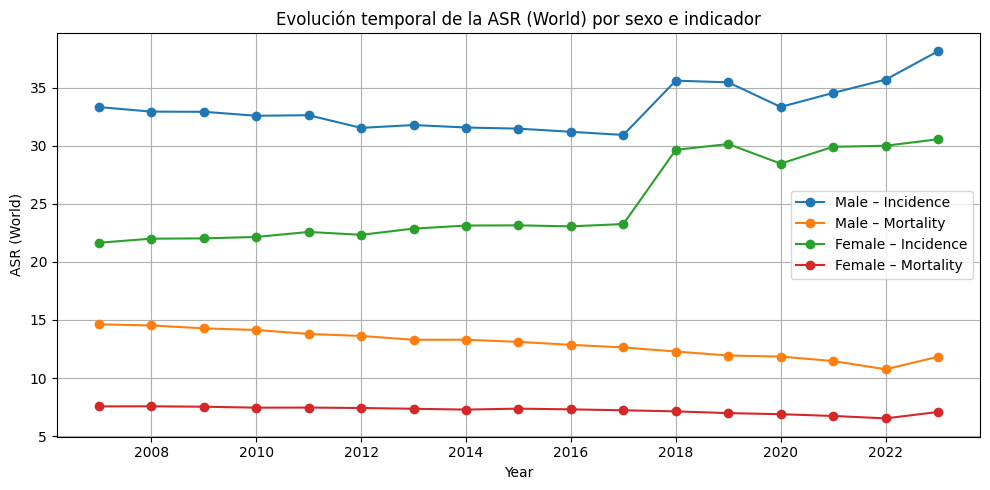

In [34]:
df_trend = (
    df_merged
    .dropna(subset=["Year", "ASR (World)", "Sex", "Type"])
    .groupby(["Year", "Sex", "Type"], as_index=False)
    .agg({"ASR (World)": "mean"})
    .sort_values("Year")
)

%matplotlib inline

plt.figure(figsize=(10,5))

for sex in ["Male", "Female"]:
    for t in ["Incidence", "Mortality"]:
        sub = df_trend[(df_trend["Sex"] == sex) & (df_trend["Type"] == t)]
        plt.plot(
            sub["Year"],
            sub["ASR (World)"],
            marker="o",
            label=f"{sex} – {t}"
        )

plt.xlabel("Year")
plt.ylabel("ASR (World)")
plt.title("Evolución temporal de la ASR (World) por sexo e indicador")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{fig_dir}/fig01_figure_ASR_anno.jpg", dpi=300, bbox_inches="tight")
plt.show()




En la serie temporal se observa un incremento aparente de las tasas a partir de 2017, que no debe interpretarse como un aumento abrupto de la incidencia real del cáncer. Este comportamiento coincide con actualizaciones metodológicas introducidas por GLOBOCAN, así como con mejoras en los sistemas de diagnóstico y registro en numerosos países, lo que puede generar discontinuidades en las series temporales.


El análisis principal se centró en la incidencia del cáncer, utilizando tasas estandarizadas por edad (ASR World), y se realizó de forma separada por sexo con el fin de preservar las diferencias epidemiológicas observadas entre hombres y mujeres.

A partir del análisis exploratorio visual, se podría seleccionar el  año 2022 como periodo de referencia, al tratarse del año más reciente y menos afectado por las distorsiones observadas durante la pandemia de COVID-19. Sin embargo, primeramente se debe ver si merece la pena usar ese año o usar otro.






In [35]:
idx = (
    df_merged
    .groupby(["Country_harmonized", "Sex", "Type"])["Year"]
    .idxmax()
)

df_latest = df_merged.loc[idx].reset_index(drop=True)


<Figure size 1000x500 with 0 Axes>

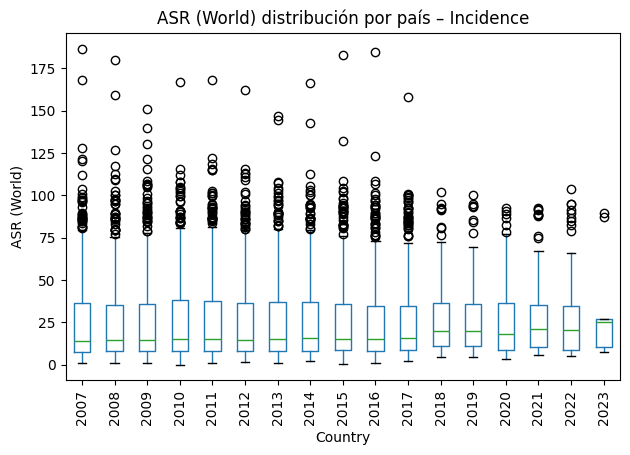

<Figure size 1000x500 with 0 Axes>

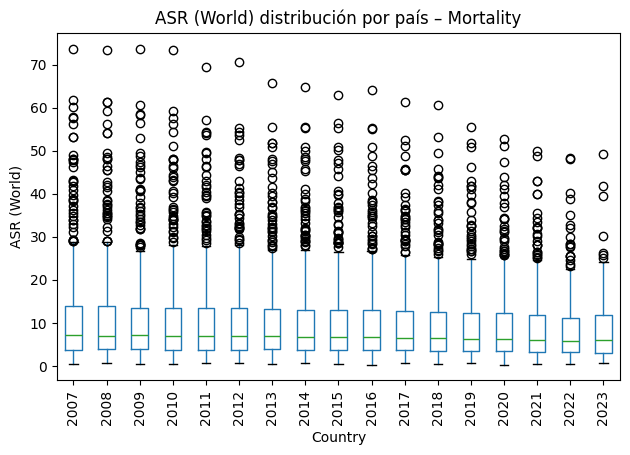

In [37]:
df_plot = df_merged.copy()


for t in df_plot["Type"].unique():
    plt.figure(figsize=(10,5))

    df_plot[df_plot["Type"] == t].boxplot(
        column="ASR (World)",
        by="Year",
        grid=False,
        rot=90
    )

    plt.title(f"ASR (World) distribución por país – {t}")
    plt.suptitle("")
    plt.xlabel("Country")
    plt.ylabel("ASR (World)")
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/fig02_boxplot_ASR_{t}.jpg", dpi=300, bbox_inches="tight")
    plt.show()


Estas figuras muestran la distribución de las tasas de incidencia y mortalidad estandarizadas por edad (ASR World) para el periodo 2007–2023 mediante diagramas de caja y bigotes. En ambos casos se observa una elevada heterogeneidad entre países, reflejada en amplios rangos intercuartílicos y la presencia sistemática de valores atípicos. La incidencia presenta una mayor dispersión que la mortalidad, lo que pone de manifiesto su mayor sensibilidad a factores como el diagnóstico precoz y la calidad de los registros. Por el contrario, la mortalidad muestra una distribución más estable y concentrada, lo que sugiere una mayor dependencia de la capacidad terapéutica de los sistemas sanitarios. Estas observaciones refuerzan la pertinencia de un análisis transversal por país y la utilización de la incidencia como variable principal, complementada por la mortalidad.

Para saber hasta donde llegan nuestro alcance con los datos, graficamos el número de países regsitrados por año.

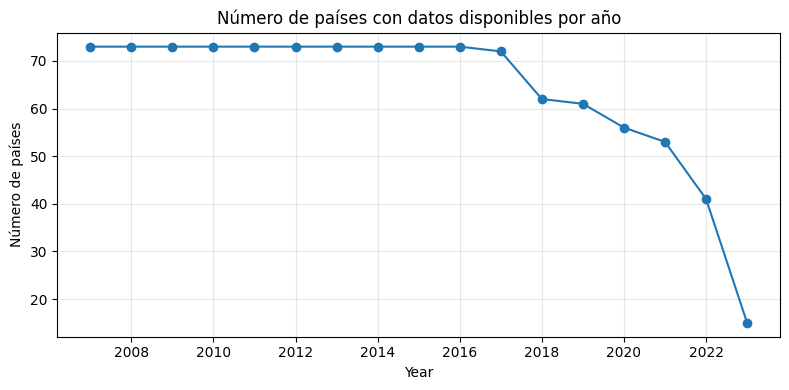

In [38]:
countries_per_year = (
    df_merged
    .groupby("Year")["Country_harmonized"]
    .nunique()
    .reset_index(name="N_countries")
    .sort_values("Year")
)
countries_per_year


%matplotlib inline

plt.figure(figsize=(8,4))
plt.plot(
    countries_per_year["Year"],
    countries_per_year["N_countries"],
    marker="o"
)

plt.xlabel("Year")
plt.ylabel("Número de países")
plt.title("Número de países con datos disponibles por año")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{fig_dir}/fig03_numero_paises_datos.jpg", dpi=300, bbox_inches="tight")
plt.show()


El análisis exploratorio de la cobertura geográfica por año mostró una estabilidad elevada hasta 2016, seguida de una reducción progresiva en los años más recientes. Por este motivo, se seleccionaron dos años de referencia: 2016, como último año con cobertura prácticamente completa, y 2022, como año reciente representativo del periodo post-pandemia. Esta estrategia permite evaluar la robustez de los resultados y analizar posibles cambios temporales sin comprometer la representatividad.

In [43]:
df_2016 = df_merged[df_merged["Year"] == 2016]
df_2022 = df_merged[df_merged["Year"] == 2022]

print("El numero de paises registrados en el 2016:", df_2016["Country_harmonized"].nunique())
print("El número de países registrados en el 2022:" , df_2022["Country_harmonized"].nunique())


El numero de paises registrados en el 2016:  73
El número de países registrados en el 2022: 41


Para poder continuar con el análisis, es importante asegurarse de que exista en cada fila incidencias y mortalidad para poder así graficarlo correctamente, por lo tanto, lo primero que se hará es limpiar esta información

In [54]:
complete_keys = (
    df_merged
    .groupby(["Country_harmonized", "Year", "Sex"])["Type"]
    .nunique()
    .reset_index()
    .query("Type == 2")
)
print(complete_keys.head())

df_complete = df_merged.merge(
    complete_keys[["Country_harmonized", "Year", "Sex"]],
    on=["Country_harmonized", "Year", "Sex"],
    how="inner"
)

df_scatter = (
    df_complete
    .groupby(["Country_harmonized", "Year", "Sex", "Type"], as_index=False)
    .agg({"ASR (World)": "mean"})
)

pivot = (
    df_scatter
    .pivot_table(
        index=["Country_harmonized", "Year", "Sex"],
        columns="Type",
        values="ASR (World)"
    )
    .reset_index()
)
pivot.isna().sum()



  Country_harmonized  Year     Sex  Type
0          Argentina  2007  Female     2
1          Argentina  2007    Male     2
2          Argentina  2008  Female     2
3          Argentina  2008    Male     2
4          Argentina  2009  Female     2


,0
Type,
Country_harmonized,0
Year,0
Sex,0
Incidence,0
Mortality,0


In [42]:
df_scatter = (
    df_merged
    .groupby(
        ["Country_harmonized", "Year", "Sex", "Type"],
        as_index=False
    )
    .agg({"ASR (World)": "mean"})
)

pivot = (
    df_scatter
    .pivot_table(
        index=["Country_harmonized", "Year", "Sex"],
        columns="Type",
        values="ASR (World)"
    )
    .reset_index()
)

print(pivot.head())

Type Country_harmonized  Year     Sex  Incidence  Mortality
0             Argentina  2007  Female  21.105817   8.274651
1             Argentina  2007    Male  22.999171  15.479395
2             Argentina  2008  Female  24.109715   8.117734
3             Argentina  2008    Male  21.814043  15.000062
4             Argentina  2009  Female  22.862996   8.199053


In [45]:
pivot.isna().sum()


,0
Type,
Country_harmonized,0
Year,0
Sex,0
Incidence,1102
Mortality,266


Haciendo un bozquejo de lo que se ha estado encontrando, se ve claramente que la mortalidad de hombres en algunos países hasta casi dobla en números con respecto a mujeres, habrá que ver por tipo de cáncer (los que afectan exclusivamente a hombres y los que afectan a las mujeres) ocasiona esta disparidad. Pero por ahora, se continúa con el análisis de mortalidad/incidencia a nivel global.

Los datos se transformaron a formato ancho mediante una tabla pivote, separando explícitamente la incidencia y la mortalidad en columnas independientes para cada combinación de país, año y sexo, lo que permitió el hint: análisis de su relación mediante correlación y regresión.


Ahora se puede calcular tanto la correlación de Pearson como, la pendiente de la curva, en el caso de ver claramente una tendencia.

In [40]:
x = pivot["Incidence"]
y = pivot["Mortality"]

#pendiente de la recta
beta, alpha = np.polyfit(x, y, 1)

#correlación de Pearson
R = np.corrcoef(x, y)[0, 1]

x_line = np.linspace(x.min(), x.max(), 100)
y_line = beta * x_line + alpha



NameError: name 'pivot' is not defined

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(
    pivot_rest["Incidence"],
    pivot_rest["Mortality"],
    alpha=0.25,
    label="Otros años"
)

plt.scatter(
    pivot_2016["Incidence"],
    pivot_2016["Mortality"],
    color="orange",
    edgecolor="black",
    s=60,
    label="2016"
)

plt.scatter(
    pivot_2022["Incidence"],
    pivot_2022["Mortality"],
    color="red",
    edgecolor="black",
    s=70,
    label="2022"
)

# Recta de regresión
plt.plot(
    x_line,
    y_line,
    color="black",
    linewidth=2,
    label=f"Regresión: y = {beta:.2f}x + {alpha:.2f}\nR = {R:.2f}"
)

plt.xlabel("Incidence ASR (World)")
plt.ylabel("Mortality ASR (World)")
plt.title("Mortality vs Incidence (ASR World)\nPendiente y correlación")

# Escala 1:1
plt.gca().set_aspect("equal", adjustable="box")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


La relación entre incidencia y mortalidad se exploró mediante diagramas de dispersión basados en ASR World, donde cada punto representa un país, año y sexo. Esta gráfica nos muestra una tendencia lineal entre incidencia y mortalidad, y se ha resaltado los años que se desean estudiar por si tienen algún patrón distinto al resto, lo que sugiere que es tiene un comportamiento similar al resto de años, por lo tanto, son buenos candidatos para el estudio que haremos más delante.

In [ ]:
pivot_2022 = pivot[pivot["Year"] == 2022]
pivot_rest = pivot[pivot["Year"] != 2022]
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Todos los años (fondo)
plt.scatter(
    pivot_rest["Incidence"],
    pivot_rest["Mortality"],
    alpha=0.3,
    label="Otros años"
)

# Año 2022 resaltado
plt.scatter(
    pivot_2022["Incidence"],
    pivot_2022["Mortality"],
    color="red",
    edgecolor="black",
    s=60,
    label="2022"
)

plt.xlabel("Incidence ASR (World)")
plt.ylabel("Mortality ASR (World)")
plt.title("Mortality vs Incidence (ASR World)\nAño 2022 resaltado")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
df_analysis = df_merged[
    (df_merged["Year"] == 2019) &
    (df_merged["Type_label"] == "Incidence")
].copy()


df_analysis.shape


## Descripción inicial de los datos
Vamos a hacer una descripción inicial de los datos


In [ ]:
#Información del Contenido
dt.info()

## Variable objetivo: creditability

 La variable **creditability** es la *calidad crediticia* de  cada cliente, es la variable a predecir. Toma originalmente dos valores (Buen Cliente y Mal Clioente). Esta es la variable objetivo, la variable evento

In [ ]:
dt["Cardhldr"].value_counts()


In [ ]:
#Recodifico esta variable creditability para que sea binaria y la llamo "y"

#dt.rename(columns={"creditability":"y"},inplace=True)
#dt['y'] = dt['y'].replace(['good', 'bad'], [0,1])
#Se construirá una tabla donde solamente hayan sido aceptado los clientes.
dt_aceptados = dt[dt['Cardhldr'] == 1]
display(dt_aceptados)

In [ ]:
#dt["y"].value_counts()
#ya filtrados los clientes, se calculan las VI
# Realizamos la trimificación optima de age.in.years

# Definir variable objetivo e independiente

# Elige variable y prepara datos
#variable = "Age"
#variable = "Income"
#variable = "Exp_Inc"
#variable = "Avgexp"
#variable = "Ownrent"
#variable = "Selfempl"
#variable = "Depndt"
#variable = "Inc_per"
#variable = "Cur_add"
#variable = "Major"
variable = "Active"


#dt_modelo = dt_aceptados.dropna(subset=["default", variable])

X = dt_aceptados[variable].values
Y = dt_aceptados["default"].values

# Crear y ajustar el binning
optb = OptimalBinning(name=variable, dtype="numerical")
optb.fit(X, Y)

# Mostrar los splits
print("Cortes óptimos:", optb.splits)

# Tabla de binning
binning_table = optb.binning_table
binning_table.build()

In [ ]:
dt.rename(columns={"default":"y"},inplace=True)
display(dt["y"].value_counts())
dt['y'].value_counts(normalize=True)

**Fíjate que tenemos un 30% de malos clientes**

In [ ]:
# Guardo los valores para su uso posterior
yT_0 = dt['y'].value_counts(normalize=True)[0]
yT_1 = dt['y'].value_counts(normalize=True)[1]
print(yT_0, yT_1)

In [ ]:
# También elimino todos los nan
dt.dropna(inplace=True)

dt.info()

## Variables Predictoras o explicativas

Las 20 restantes variables del data frame (7 numéricas y 13 categóricas) son los atributos o características observadas de esos clientes que se utilizarán para predecir la probabilidad de que los clientes cometan un impago de sis créditos, esto es, de que sean malos clientes. La descripción de estas 20 variables es la siguiente:

In [ ]:
#  - Attribute 1: (qualitative) **Status of existing checking account o cuenta corriente**
#   - A11 : ... < 0 DM
#   - A12 : 0 <= ... < 200 DM
#   - A13 : ... >= 200 DM / salary assignments for at least 1 year
#   - A14 : no checking account

#- Attribute 2: (numerical) **Duration in month**

#  - Attribute 3: (qualitative) **Credit history**
#     - A30 : no credits taken/ all credits paid back duly (devultos sin mora)
#     - A31 : all credits at this bank paid back duly
#     - A32 : existing credits paid back duly till now
#     - A33 : delay in paying off in the past
#     - A34 : critical account/ other credits existing (not at this bank)

# - Attribute 4: (qualitative) **Purpose**
#     - A40 : car (new)
#     - A41 : car (used)
#     - A42 : furniture/equipment
#     - A43 : radio/television
#     - A44 : domestic appliances
#     - A45 : repairs
#     - A46 : education
#     - A47 : (vacation - does not exist?)
#     - A48 : retraining
#     - A49 : business
#    - A410 : others

# - Attribute 5: (numerical) **Credit amount**

# - Attribute 6: (qualitative) **Savings account/bonds**
#    - A61 : ... < 100 DM
#    - A62 : 100 <= ... < 500 DM
#    - A63 : 500 <= ... < 1000 DM
#    - A64 : .. >= 1000 DM
#    - A65 : unknown/ no savings account

# - Attribute 7: (qualitative) **Present employment since**
#     - A71 : unemployed
#     - A72 : ... < 1 year
#     - A73 : 1 <= ... < 4 years
#     - A74 : 4 <= ... < 7 years
#     - A75 : .. >= 7 years

# - Attribute 8: (numerical) **Installment rate in percentage of disposable income**

#  - Attribute 9: (qualitative) **Personal status and sex**
#     - A91 : male : divorced/separated
#     - A92 : female : divorced/separated/married
#     - A93 : male : single
#     - A94 : male : married/widowed
#     - A95 : female : single

# - Attribute 10: (qualitative) **Other debtors / guarantors**
#    - A101 : none
#    - A102 : co-applicant
#    - A103 : guarantor

# - Attribute 11: (numerical) **Present residence since**

# - Attribute 12: (qualitative) **Property**
#     - A121 : real estate
#     - A122 : if not A121 : building society savings agreement/ life insurance
#     - A123 : if not A121/A122 : car or other, not in attribute 6
#     - A124 : unknown / no property

# - Attribute 13: (numerical) **Age in years**

# - Attribute 14: (qualitative) **Other installment plans** Otros pagos por plazos
#      - A141 : bank
#      - A142 : stores
#      - A143 : none

# - Attribute 15: (qualitative) **Housing**
#      - A151 : rent
#      - A152 : own
#      - A153 : for free

# - Attribute 16: (numerical) **Number of existing credits at this bank**

# - Attribute 17: (qualitative) **Job**
#   - A171 : unemployed/ unskilled - non-resident
#   - A172 : unskilled - resident
#   - A173 : skilled employee / official
#   - A174 : management/ self-employed/highly qualified employee/ officer

# - Attribute 18: (numerical) **Number of people being liable to provide maintenance for**

# - Attribute 19: (qualitative) **Telephone**
#   - A191 : none
#   - A192 : yes, registered under the customers name

# - Attribute 20: (qualitative) **foreign worker**
#   - A201 : yes
#   - A202 : no



## Analisis univariante y de asociación con la variable objetivo

Que comprobar en el análisis descriptivo inicial?

### **Análisis univariante**

1- **Tipos de variables**. Todas las variables categóricas (factores) están bien identificadas?


Para el análisis univariante es importante realizar un análisis gráfico con el **Histograma de Frecuencias**

2- **Límites de las variables cuantitativas** Valores numéricos fuera de rango ¿Hay alguna limitación sobre el rango de alguna variable que no se cumpla?

3- **Niveles de las variables cualitativas**, Valores mal codificados ¿los niveles de las variables cualitativas tienen sentido? ¿Hay missings no declarados tipo -1, 99999? Las categorías de las nominales son las que deben?

4- **Variables nominales o categóricas o factores con categorías minoritarias**.Frecuencia de las categorías de las variables cualitativas.  Las categorías con baja representación puede causar muchos problemas en los modelos por falta de base muestral para la estimación de los parámetros correspondientes a la pertenencia a esa categoría. Por ello, es conveniente echar un vistazo y recodificar las vairables uniendo categorías muy poco representativas con otras cuya unión tenga algún sentido (tienen comportamiento similar frente a la objetivo, la variable tiene caracter ordinal por lo que la unión con mayor sentido sería hacia categorías adyacentes..).  Es imprescindible que todas los niveles de las variables cualitativas esten ´ bien representados pues, de lo contrario, se podr´ıan detectar patrones que no fueran extrapolables al estar basados en muy pocas observaciones.
 Por ello, se debe verificar que la frecuencia de todas ellas sea superior al 2-5 % (el porcentaje exacto depende del numero de observaciones del conjunto de datos) Yo prefiero que haya variabilidad suficiente: NO debe haber categorías con menos de un 5% de representación).

5 **Variabilidad suficiente de las variables numéricas** Por encima de un 5% de valores distintos


Con estas cosas ya arregladas, nos vamos a los dos grandes "caballos de batalla" de la depuración.

5- **Outliers**. Incidencia y tratamiento (pasar a missing, eliminar, winsorizar o reemplazarlos con los valores no atípicos más cercanos)

**Análisis de las variables/casos ausentes**


6- **Missings**. Incidencia y tratamiento
  - **Imputación** por valores validos (0-5%):  simple por media, mediana, aleatorio, imputación por modelos
  - **Recategorizacion** (5%- 50%) de los valores missing como una categoría valida.
  - **Eliminar** columnas u observaciones (superior al 50 %) Cuando en una variable hay mas de la mitad de los datos faltantes, es recomendable rechazarla al inicio del proceso, pues carece de suficiente informacion.
  

### **Análisis Bivariante**
**Después del análisis Univariante se realiza el Análisis Bivariante, entre cada una de las potenciales variables explicativas y la Variable objetivo**

a. Tablas de contigencia Chi2 (¿discretizar variables continuas V de Cramer o Chi2 dnormalizado entre 0 y 1,, independientes y totalmente dependientes respectivamente))
b. Tablas de correlaciones
c. Tablas Pivote (test de diferencia de medias)

c) Métodos gráficos:
  - Gráficos de dispersión
  - Diagrama de Cajas o boxplot (o diagrama de barras)
  - diagrams de mosaicos



***


## Análisis exploratorio inicial de las **variables categóricas**

Comenzamos con el análisis de las variables discretas

In [ ]:
dt.describe(include='object')

### **status.of.existing.checking.account**

In [ ]:
# tabla de distribución de frecuencia univariante
dt['status.of.existing.checking.account'].value_counts(normalize=True,dropna=False).sort_index()

In [ ]:
# tabla de contingencia: distribución de frecuencias bi-variante
ctabla=pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True).round(3)
ctabla

In [ ]:
# test Chi-cuadrado de independencia (Ho: ausencia de asociación)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print(p)

In [ ]:
# tabla de contingencia agrupada por columnas (axis=1), Se puede analizar la importancia relativa comparando con los porcentajes clobales.
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=1).round(3)

In [ ]:
# Porcentajes respecto al total de cada fila (normalize=0), habría que comparar con el porcentaje de eventos en el total de la muestra (30%)
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3)

In [ ]:
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))


In [ ]:
# Para comparar respecto a los totales

pd.crosstab(dt['status.of.existing.checking.account'], dt['y'], margins=True, normalize=0).round(3).plot(figsize=(15, 5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Personal status and sex**

In [ ]:
dt['personal.status.and.sex'].value_counts(normalize=True,dropna=False).sort_index()

In [ ]:
ctabla=pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True).round(3)
ctabla

In [ ]:
# test Chi-cuadrado de independencia (Ho: ausencia de asociación)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print(p)

In [ ]:
pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True, normalize=0).round(3)

In [ ]:
pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Housing**

In [ ]:
dt['housing'].value_counts(normalize=True,dropna=False).sort_index()

In [ ]:
ctabla=pd.crosstab(dt['housing'],dt['y'],margins=True).round(3)
ctabla

In [ ]:
# test Chi-cuadrado de independencia (Ho: ausencia de asociación)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print(p)

In [ ]:
pd.crosstab(dt['housing'],dt['y'],margins=True, normalize=0).round(3)

In [ ]:
pd.crosstab(dt['housing'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Job**

In [ ]:
dt['job'].value_counts(normalize=True,dropna=False).sort_index()

In [ ]:
ctabla=pd.crosstab(dt['job'],dt['y'],margins=True).round(3)
ctabla

In [ ]:
# test Chi-cuadrado de independencia (Ho: ausencia de asociación)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print(p)

In [ ]:
pd.crosstab(dt['job'],dt['y'],margins=True, normalize=0).round(3)

In [ ]:
pd.crosstab(dt['job'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

 ....  Habría que seguir haciendo esto con todas las variables categóricas para analizar asociación

## Analisis univariante y de asociación con la variable objetivo de las **Variables continuas**

In [ ]:
dt.describe()

### **Credit.amount**

In [ ]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True)
plt.show()

Parece que como la mayoría de variables económicas tipo cantidad de dinero (precios, salarios, rentas, etc) se comportan como una log normal. Lo comprobamos gráficamente

In [ ]:
sns.displot(x=np.log(dt['credit.amount']), kind="kde", fill=True)
plt.show()

Vamos a transformar la variable 'credit.amount' en logaritmos para conseguir normalidad (o al menos que se parezca a una normal)

In [ ]:
dt['credit.amount']=np.log(dt['credit.amount'])

Ahora vamos a ver si hay diferencias en la distribución de la variable 'credit.amount' entre los buenos y los malos clientes

In [ ]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

Según el histograma sí parece haber asociación, al menos hay tres tramos bien diferenciados, uno primero donde es difícil diferenciar entre los buenos y malos, otro tramo donde hay una mayor cantidad relativa de buenos clientes, y un tercero, en el que a partir de una determinada cantidad de crédito hay una mayoría relativa de malos clientes.    

Parece por tanto que sí hay asociación entre creditability (impago) y la cantidad de dinero que se solicita en el préstamo. PAra comprobarlo hacemos el test de diferencias de medias (Ho:igualdad de medias, esto es, ausencia de asociación)

In [ ]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['credit.amount']], dt.loc[dt["y"]==1,['credit.amount']])
print(fvalue, pvalue)


Hacemos la misma comprobación con el resto de variables

### **duration.in.month**

In [ ]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True)
plt.show()

In [ ]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

In [ ]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['duration.in.month']], dt.loc[dt["y"]==1,['duration.in.month']])
print(fvalue, pvalue)

Tendría que continuar con el análisis del resto de variables continuas .....

In [ ]:
sns.pairplot(dt, hue="y")

# **Selección de Variables**: análisis de Concentración para seleccionar las variables más **importantes** para meter en el modelo

### Dividimos la muestra en entrenamiento y test     

Comenzamos ya el proceso de construcción del modelo en sentido estricto. Por eso lo primero es partir la muestra para comprobar la bondad del modelo que estimemos.



In [ ]:
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=1234)

In [ ]:
# Realizamos la trimificación optima de age.in.years
variable="age.in.years"
X=dt_train[variable].values
Y=dt_train['y'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(X, Y)
optb.splits
binning_table = optb.binning_table
binning_table.build()

In [ ]:
dt_train["y"].shape

In [ ]:
dt_train["y"].mean()

In [ ]:
dt_test["y"].shape

In [ ]:
dt_test["y"].mean()

## Defino la tramificación óptima

## Tramificación de la Variable: "credit.amount"

In [ ]:
variable="credit.amount"
X=dt_train[variable].values
Y=dt_train['y'].values

In [ ]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

# Si se quisiese fijar los intervalos manualmente (porque no gusten los que obtine el agoritmo, entonces habría que usar:
#                     user_splits=
#                     user_splits_fixed=
# HAy veces que los datos tienen dátos missing y códigos especiales en este caso para obtener una categoría con esos datos missing y datos especiales hay que establecerlos
#                     special_codes = [-9, -8, -7]

# Una vez definido podemos pasar a estimarlo
optb.fit(X, Y)
optb.splits

Nota: Por defecto se utiliza un arbol de clasificación para hacer una tramificación inicial, y después se aplica un proceso de optimización de agrupación de categorías para maximizar el Valor de Información

Una vez realizado el proceso de tramificación y agrupación óptima de categorías, obtenemos la tabla de agrupación

In [ ]:
binning_table = optb.binning_table
binning_table.build()

Cabe mencionar que el WOE en esta tabla parece estar definido al revés que lo hemos hecho en clase, por lo que el signo es justo el contrario al que cabría esperar según lo que hemos visto en clase. En particular por defecto `optbinning` define el WOE de una categoría $i$ como
$$ WOE_i =  ln \left ( {Non-event_i \over Non-event_{total}} \over {Event_i \over Event_{total}}    \right ) $$

En este sentido los niveles con mayor tasa de impagados tendrán un WOE menos, y a medida que se reduzca la tasa de impagados (mejor calidad crediticia) irá aumentando el WOE. De hecho, 'optbinning' ni siquiera utiliza la misma fórmula que yo he utilizado en clase, por lo que no está acotada entre cero y uno, puede valos más que uno sin que eso signifique sobre ajuste.

Por talmotivo utilizaremos como criterio de selección exclusivamente IV<0.002

Podemos extraer el IV y el índice de Gini a partir de la tabla

In [ ]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))

# La última columna muestra el estadístico Jensen-Shannon de divergencia.
# Es una medida de la similaridad entre dos distribuciones de probabilidad (frecuencias de buenos y malos )
# que está acotada entre 0 y log2 (aprox 0.70) (puede utilizarse 0.01 como mínimo)
print("JS= ", binning_table.js.round(3))



In [ ]:
# Podemos profundizar en el análisis estimando otras
binning_table.analysis(pvalue_test="chi2")


In [ ]:
# Por ejemplo otra medida que suele utilizarse en el Quality score(QS) que está acotada entre 0 y 1 (puede utilizarse 0.01 como mínimo)
print("QS= ", binning_table.quality_score.round(3))

In [ ]:
# La tabla anterior también muestra la V de Cramer (por encima de 0.20 podría ser suficiente para decir que hay asociación, entre los tramos y el porcentaje de eventos

# Pero también podemos realizar el test con la tabla de contigencia completa:Jensen-Sha
x_transform_indices = optb.transform(X, metric="indices")

#pd.Series(x_transform_indices).value_counts(normalize=True,dropna=False).sort_index()
ctabla=pd.crosstab(pd.Series(x_transform_indices),Y,margins=True).round(3)
print(ctabla)

# Chi-square test of independence. Ho: Ausencia de Asociación (independencia)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print("Test independencia. Estadístico :" ,round(c,3), "p-valor:", round(p,3))

Podemos realizar una representación gráfica de la Tabla de tramificación

In [ ]:
binning_table.plot(metric="woe")

In [ ]:
binning_table.plot(metric="event_rate")

Nótese que la relación entre lavariable x (credit.amount) y la tasa de evento (impago) es **no-lineal**

Ahora podemos aplicar esta tramificación óptima a la variable original y obtener la variable transformada WOE (que será una variable continua que utilizaremos en el modelode regresión)

In [ ]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index()

Fíjate que ahora hemos conseguido "linealizar" la relación entre la variable trasnformada Woe y la propensión al impago

In [ ]:
pd.crosstab(x_woe,Y,normalize=0).round(3)

In [ ]:
fig, ax = plt.subplots()
ax.plot(pd.crosstab(x_woe,Y,normalize=0).iloc[:,1])
ax.set_xlabel("x_woe")
ax.set_ylabel("porcentaje de impago")

Nótese que para hacer la validación deberíamos hacer exactamente la misma transformación WOE, con la misma tramificación, al conjunto test. Para ello debemos aplicar la transformación optima calculada con el conjunto de entrenamiento, pero sobre la muestra de validación

In [ ]:
# Transformación WOE en el conjunto test
x_test_woe = optb.transform(dt_test[variable].values, metric="woe")
pd.Series(x_test_woe).value_counts().sort_index()

Nótese que **no** estamos calculando una nueva tramificación para el conjunto de test, sino aplicando la tramificación obtenida con el conjunto de entrenamiento.    
En realidad si hiciéramos una tramificación óptima con el conjunto de test no tendría porqué salir igual que la estimada para el conunto de entrenamiento, como se puede comprobar a continuación

In [ ]:
variable="credit.amount"
X_test=dt_test[variable].values
Y_test=dt_test['y'].values
optb_test = OptimalBinning(name=variable, dtype="numerical")
optb_test.fit(X_test, Y_test)
print(optb_test.splits)
binning_table_test = optb_test.binning_table
binning_table_test.build()

Nótese que con el conjunto de test se han obtenido sólo 6 tramos y con diferentes puntos de corte ( y diferentes WOE), por eso es necesario no hacer una nueva tramificación al conjnto de test sino aplicar la tramificación obtenida usando en el conjunto de entrenamiento

## Tramificación de la duración en meses

In [ ]:
variable="duration.in.month"
X=dt_train[variable].values
Y=dt_train['y'].values

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

optb.fit(X, Y)
optb.splits

In [ ]:
binning_table = optb.binning_table
binning_table.build()

In [ ]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))


In [ ]:
binning_table.plot(metric="woe")

In [ ]:
binning_table.plot(metric="event_rate")

In [ ]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index

Habría que seguir con el resto de variables continuas.....

# Agrupción de niveles en variables Vbles Categóricas

En realidad, cuando tenemosvariables categóricas, no es necesario tramificar, pero sí hacer una agrupación de los diferentes niveles de forma que se maximice el *valor de información*

## Agrupación de la variable  *purpose*

In [ ]:
variable_cat = "purpose"
X_cat = dt_train[variable_cat].values
Y_cat = dt_train['y'].values

dt_train[variable_cat].value_counts()

In [ ]:

optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="cp",
                      cat_cutoff=0.1)  # podemos cambiar los valores por defecto cat_cutoff=None, o, cat_cutoff=0.005

optb.fit(X_cat, Y_cat)
optb.splits

In [ ]:
binning_table = optb.binning_table
binning_table.build()

In [ ]:
binning_table.plot(metric="event_rate")

In [ ]:
x_woe = optb.transform(X_cat, metric="woe")
pd.Series(x_woe).value_counts()


... habría que seguir con el resto de variables categóricas

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

# Proceso de tramificación, agrupación y trasformación WOE Completo

Para no ir variable a variable se puede hacer todo el proceso completo

Proceso Entero



In [ ]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [ ]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02}  # no imponemos "max": 1}
}

In [ ]:
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

In [ ]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

In [ ]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [ ]:
dt_train_binned.summary().sort_values('iv')

In [ ]:
# Ahora podemos ir sacando las tablas para cada variable

dt_train_binned.get_binned_variable("credit.amount").binning_table.build()

In [ ]:
dt_train_binned.get_binned_variable("purpose").binning_table.build()

In [ ]:
dt_train_binned.information()

In [ ]:
# las variables seleccionadas se pueden obtener con 'get_support'"Tarea Estudiantes_TarjetaPuntuacion"
dt_train_binned.get_support()

In [ ]:
# Podemos transformar las variables WOE
dt_train_woe=dt_train_binned.transform(X, metric="woe")


# Existe la posibilidad de obtener directamente las transformada si en lugar de usar fit, hubiésemos usado fit_transform
# dt_train_binned = binning_process.fit_transform(X, Y)
# dt_train_binned.info()
# el resultado sería un data.frame con las X seleccionadas trasnsformadas WOE



In [ ]:
dt_train_woe.info()

In [ ]:
dt_train_woe

In [ ]:
# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

dt_test_woe=dt_train_binned.transform(X_test, metric="woe")
dt_test_woe.info()





In [ ]:
dt_test_woe

# Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener:

 $$ score {= offset - Factor}~·~{ln(odds)}$$

Para pasar de Probabiliddes de impago a Puntuaciones, habrá que establecer tanto el valor de `offset` como el de `Factor`. Esto se hace de manera arbitraria dependiendo de cada institución financiera.

En general, para determinar estos dos valores es necesario establecer la pendiente de la recta y un punto de la misma.

En cuanto a la pendiente, cuanto más plana sea la pendiente, menor variabilidad tendrán los valores de puntuación de crédito que se alcancen, y al revés, cuanto mayor pendiente más diferencias en la puntuación final. Yo voy a utilizar un apendiente (arbitraria) estableciendo de forma arbitraria cada cuantos puntos de score (**pdo_0**) se dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$.

 En cuanto al punto de la recta (arbitrario), puede hacerse estableciento (de manera arbitraria) la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**)

 Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40  (esto es que cada 40 puntos de calidad creditica se dobla el odd-ratio))
* **scorecard_points** =600  (alguien con calidad crediticia muy buena, de sobresaliente, sacaría 600 puntos)
* **odds_0** =1/50  (odd ratio que se considera de sobresaliente)

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1).
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$

 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )




In [ ]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

In [ ]:
# Podemos obtener los parámetros del modelo de regresión logística
tarjeta.table(style="detailed")[["Variable","Coefficient"]].groupby(["Variable", "Coefficient"]).nunique()

Y podemos obtener los puntos de la tarjeta de puntuación

In [ ]:
tarjeta.table().head(60)

In [ ]:
#Aquí se obtienen todos los estadísticos
tarjeta.table(style="detailed").head(16)

Continuamos con la Diagnosis del Modelo

In [ ]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(4)


Para contruir las matrices de confusión necesitamos determinar un **punto de corte de la probabilidad**.    

Ese punto de corte es el que me va a ayudar a realizar un pronóstico sobre los clientes: los malos clientes serán aquellos para los que Prob Estimada > Prob_corte.


In [ ]:
# Para elegir el punto de corte puede utilizarse el Plot Kolmogorov-Smirnov (KS)
plot_ks(Y, Y_pred)

In [ ]:
# También puede utilizarse el máximo del f1_score
# definimos un vector de puntos de corte
c=np.arange(0,1,0.01)
# calculamos el f1_score para cada punto de corte
f1_score_ = [f1_score(dt_train["y"],np.multiply(Y_pred>c_,1)) for c_ in c]
# obtenemos el punto de corte que maximiza el f1_score
c_max = c[np.argmax(f1_score_)]
print("El punto de corte que maximiza el f1_score es: ", c_max)
print("y el máximo se alcanza en ", np.max(f1_score_).round(3))

# hacemos un gráfico de c y los f1_score correspondientes
plt.plot(c,f1_score_)
plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico f1_score vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)))
plt.show()

c_maxF1=c_max

In [ ]:
# método de Youden (J) para obtener el punto de corte óptimo
# definimos un vector de puntos de corte (c) y de probabilidad de aceptación (p)
c=np.arange(0,1,0.01)

# Calculamos el estadístico J de Youden para cada punto de corte= Sensibilidad + Especificidad -1
J= [balanced_accuracy_score(dt_train["y"],np.multiply(Y_pred>c_,1), adjusted=True) for c_ in c ]
# obtenemos el punto de corte que maximiza el índice de Youden
c_max = c[np.argmax(J)]
print("El punto de corte que maximiza el índice de Youden es: ", c_max)
print("y el máximo se alcanza en ", np.max(J).round(3))

# gráfico de c y los índices de Youden correspondientes
plt.plot(c,J)
plt.stem(c_max, np.max(J),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico índice de Youden vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n J_max = "+str(np.max(J).round(3)))
plt.show()

In [ ]:
# Para el punto de corte se podría utilizar simplemente la frecuencia observada, o utilizar el punto donde se alcanza el maximo del F1 Score
Prob_Corte=Y.mean()
# Prob_Corte=c_maxF1
print(' Punto de Corte seleccionado:', Prob_Corte.round(2),'\n',
      'Frecuencia media de eventos (y=1):', Y.mean().round(2), '\n',
      'máximo del F1-score :', c_maxF1)

Ahora ya podemos hacer los pronósticos

In [ ]:
dt_train["Y_pronostico"]=np.multiply(Y_pred>Prob_Corte,1)

Para comprobar la bondad de nuestras predicciones voy a comparar resultados con la tabla de confusión

In [ ]:


# Primero estimo la precisión (los aciertos sobre el total de mis pronósticos)
pd.crosstab(dt_train["y"],dt_train["Y_pronostico"],margins=True, normalize=1).round(3)


Nótese que los falsos negativos (Bad Rate) es del 11.5% (préstamos aceptados o pronosticados como buenos que resultaron impagados)

In [ ]:
# Ahora estimo la exhaustividad o recall (Aciertos sobre los casos reales):
# la sensibilidad (sobre los positivos y=1), y la Especificidad (sobre los negativos y=0)

pd.crosstab(dt_train["y"],dt_train["Y_pronostico"],margins=True, normalize=0).round(3)

In [ ]:
# Por último un resumen global de aciertos
f1_score(dt_train["y"],dt_train["Y_pronostico"])

Para hacer la diagnosis también puedo utilizar medidas que no dependan crucialmente de un único punto de corte de Probabilidad

In [ ]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

In [ ]:
# Diagnosis Cumulative Accuracy Profile (CAP)
# Otra curva alternativa a la curva ROC que permite evaluar la bondad de un modelo de clasificación es la curva CAP (Cumulative Accuracy Profile).
# La curva CAP se construye de la siguiente manera: ordenamos las observaciones de mayor a menor probabilidad
# de pertenecer a la clase positiva (y=1). A continuación, vamos acumulando las observaciones y calculando
# la proporción de positivos acumulados sobre el total de positivos. Esta proporción se representa en el eje Y.

# En el eje X representamos la proporción de observaciones acumuladas sobre el total de observaciones.
# La curva CAP se construye a partir de la curva de la línea recta (curva de referencia) y
# la curva de la línea que representa la probabilidad estimada por el modelo.

plot_cap(Y, Y_pred)

In [ ]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Calculamos la media
Y_test_pred.mean().round(5)

In [ ]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


In [ ]:
plot_cap(Y_test,Y_test_pred)

In [ ]:
dt_test["Y_pronostico"]=np.multiply(Y_test_pred>Prob_Corte,1)

# Primero estimo la precisión (los aciertos sobre el total de mis pronósticos)
print("\n Precisión:\n", pd.crosstab(dt_test["y"],dt_test["Y_pronostico"],margins=True, normalize=1).round(3))

# Ahora estimo la exhaustividad o recall (Aciertos sobre los casos reales):
# la sensibilidad (sobre los positivos y=1), y la Especificidad (sobre los negativos y=0)
print("\n exhaustividad:\n",pd.crosstab(dt_test["y"],dt_test["Y_pronostico"],margins=True, normalize=0).round(3))

# Por último un resumen global de aciertos
print("\n f1-score:",f1_score(dt_test["y"],dt_test["Y_pronostico"]))

Pasamos ahora de Probabilidades a Puntuaciones

In [ ]:
# Ahora vamos a calcular los score o puntuaciones.
# Que podemos hacer  con la función score
score = tarjeta.score(X)

print("Puntuación mínima: ", score.min().round(2))
print("Puntuación máxima: ",score.max().round(2))
print("Puntuación media : ",score.mean().round(2))


# O también haber calculado la puntuación manualmente (voy a calcularla para comprobar que da exactamente el mismo resultado)

# Transformación lineal según apuntes
# Factor= (pdo_0/log(2))
# Offset = scorecard_points_0+(pdo_0/log(2))*log(odds0_0)
# score= Offset - Factor *log(odds)

Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)

score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

# Podemos comprobar que los resultados son los mismos
print("Puntuación mínima cálculo manual: ",score2.min().round(2))
print("Puntuación máxima cálculo manual: ",score2.max().round(2))
print("Puntuación media cálculo manual : ",score2.mean().round(2))

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])

# si es necesario podemos guardar los datos
# datos_score.to_excel("score_p1.xlsx")


Saber cómo se hace la transformación manual puede ayudarnos por ejemplo a la hora de establecer la `nota que determina el aprobado`. Imaginemos que utilizamos la frecuencia observada de impagos como probabilidad de corte

In [ ]:

Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("La probabilida de corte de: ", Prob_Corte, " equivale a una puntuación de corte de: ", Score_Corte.round(2) )


In [ ]:
# Ahora representamos en un gráfico cómo separa el modelo a los buenos y los malos
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True, common_norm=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

# Seguimiento del modelo: PSI (Population Stability Index)
El PSI es una medida de diferencia en la distribución de dos muestras, en nuestro caso entre la muestra utilizada para construir el modelo (entrenar y validar el modelo), y los nuevos datos que se vayan obteniendo con el transcurso del tiempo.  

Se aplica para detectar cuándo comienzan a verse diferencias entre las dos muestras (las puntuaciones de la muestra -train- y las puntuaciones obtenidas con los nuevos datos .... Cuando las distribuciones dejen de parecerse será el momento de revisar el modelo a tenor de los nuevos datos

Como regla general
  - **PSI <0.1**: No hay diferencias significativas entre las muestras de entrenamiento y los nuevos datos (resultado deseado, no se requiere más acciones)
  - **PSI entre 0.1 y 0.25** Hay cambio menores, valdría la pena revisar el modelo
  - **PSI >0.25** hay cambios importantes entre las dos muestras HAY QUE CAMBIAR EL MODELO


In [ ]:
# Supongamos que tenemos un conjunto de nuevos datos que hemos ido recopilando después de la puesta en producción del modelo,
# y queremos utilizar esos nuevos datos para saber si es necesario revisar el modelo o si por el contrario podemos seguir utilizándolo

# Como en la base de datos no disponemos de este tipo de datos voy a suponer simplemente que los datos de test son los nuevos datos,

dt_nuevosdatos= dt_test.copy()


# Valores nuevos
Y_nuevo = dt_nuevosdatos['y'].values
X_nuevo = dt_nuevosdatos.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

# Valores de entrenamiento
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la variable y




In [ ]:
# ¿se distibuyen igual las probabilidades esperadas?
score_train = tarjeta.score(X)
score_nuevo = tarjeta.score(X_nuevo)

datos_score_psi1=pd.DataFrame(np.transpose([score_train,Y]), columns=['score','Y'])
datos_score_psi1['tipo']='entrenamiento'

datos_score_psi2=pd.DataFrame(np.transpose([score_nuevo,Y_nuevo]), columns=['score','Y'])
datos_score_psi2['tipo']='nuevos datos'

datos_score_psi= pd.concat([datos_score_psi1,datos_score_psi2])
sns.displot(data=datos_score_psi, x='score', label="event", hue='tipo', alpha=0.35,kind="kde", fill=True,common_norm=False)
plt.axvline(Score_Corte, color='k', linestyle=":")
plt.show()

Aparentemente las distribuciones son parecidas, eso quiere decir que los nuevos datos se parecen a los utilizados en el entrenamiento del modelo, por lo que seguramente no es necesario revisar el modelo. Lo comprobamos de todas formas con el estadístico PSI (Population Stability Index)

In [ ]:
# Estimo el psi
# Defino la tarjeta a evalear
# psi=ScorecardMonitoring(tarjeta, psi_method="cart",psi_min_bin_size=0.05, psi_n_bins=13)
psi=ScorecardMonitoring(tarjeta, psi_method= "quantile", psi_n_bins=10)
psi.fit(X_actual=X_nuevo, y_actual=Y_nuevo, X_expected=X, y_expected=Y)

psi.psi_plot()
psi.psi_table()
psi.tests_table()


In [ ]:
psi.system_stability_report()

In [ ]:
psi.psi_variable_table(style="summary").sort_values('PSI')